# An Empirical Study of the Runtime Complexity of Bellard's Algorithm for Calculating Digits of π

## Introduction
In his article *"Computation of the n'th digit of pi in any base in O(n^2),"* Fabrice Bellard [2007] described a way of calculating the digits of $\pi$ in any base $B$ in $O(n^2)$ time. This algorithm is an improvement from the earlier algorithm described by Simon Plouffe [1996] which attempts to calculate the $n$th digit of various transcendental numbers (including $\pi$) in $O(n^3\log^3(n))$ time. With the memory complexity of Bellard's Algorithm staying at a constant $O(1)$, Bellard claims his algorithm would "...[make] it practical to compute the millionth digit of $\pi$ for example." [1] Thus, in implementing Bellard's Algorithm into native C++ code, a closer inspection of this modified Bailey–Borwein–Plouffe algorithm should uncover real-world imperfections when generating digits of $\pi$. Further statistical analysis would take place on the telemetric data collected by the software implementation of Bellard's Algorithm to show underlying trends in runtime complexity.

## Methodology
When beginning the process of implementing Bellard's Algorithm, many operational environmental factors will need to be considered. For instance, the hardware used in computing the digits of $\pi$ can vary greatly. The on-site hardware is an AMD Ryzen 7 5800X 8-Core Processor with 32 GB of Double Data Rate 4 Synchronous Dynamic Random-Access Memory. As a control, the implemented code will not take advantage of multithreading. Even then, the single-threaded performance of the AMD Ryzen 7 5800X 8-Core Processor may shift the metrics but not impact the general shape of the data. Knowing which programming language to use was also an issue, as many high-level programming languages may abstract away low-level performance optimizations. C++ was chosen for its performance and intricate control over the CPU. The implemented code shown is under a namespace, as it is integrated with other code which handles business logic. Their implementation is not within the scope of this study and will not be shown. As data type limitations exist in C++, many of the implementation code will rely on modular multiplication, modular inverses, and modular exponentiation. The implementation for modular multiplication is a preprocessor macro:

```cpp
#define MUL_MOD(a, b, m) ((static_cast<long long>(a) * static_cast<long long>(b)) % (m))
```

This is under the assumption that machines running the program will have access to 64-bit integer data types. A 32-bit version is also provided:

```cpp
#define MUL_MOD(a, b, m) fmod(static_cast<double>(a) * static_cast<double>(b), m)
```

The 32-bit version utilizes the floating-point modulo function from `math.h`. The functions for modular inverses and modular exponentiation are implemented below:

```cpp
static int ComputeDigit::inv_mod(const int x, const int y)
{
	int u = x, v = y, c = 1, a = 0;
	do
	{
		const int q = v / u;
		int t = c;
		c = a - q * c;
		a = t;
		t = u;
		u = v - q * u;
		v = t;
	} while (u != 0);
	a %= y;
	if (a < 0)
		a += y;
	return a;
}

static int ComputeDigit::pow_mod(const int a, int b, const int m)
{
	int r = 1, aa = a;
	while (true)
	{
		if (b & 1)
			r = MUL_MOD(r, aa, m);
		b >>= 1;
		if (b == 0)
			break;
		aa = MUL_MOD(aa, aa, m);
	}
	return r;
}
```

The implementation for modular exponentiation employs bitwise operations and the preprocessor macro defined earlier for modular multiplication. As Bellard mentioned, in order to compute $\pi$ to $n$ digits in base $B$, all prime numbers $p$ satisfying the condition $2 < p < \lfloor (n + \epsilon) \log_2(B) \rfloor$ ($\epsilon$ is a precision-control integer) will need to be iterated through [1]. Therefore, it is necessary to implement the following two functions which will generate prime numbers.

```cpp
static bool ComputeDigit::is_prime(const int n)
{
	if (n % 2 == 0)
		return false;
	const int r = static_cast<int>(sqrt(n));
	for (int i = 3; i <= r; i += 2)
		if (n % i == 0)
			return false;
	return true;
}

static int ComputeDigit::next_prime(int n)
{
	do n++; while (!is_prime(n));
	return n;
}
```

These two functions, along with modular multiplication, modular inverses, and modular exponentiation, will be crucial to implementing the main algorithm described below:

```cpp
int ComputeDigit::digit_at(const int n)
{
	double sum = 0;
	const int N = static_cast<int>((n + 20) * log(10) / log(2));
	for (int a = 3; a <= 2 * N; a = next_prime(a))
	{
		const int vmax = static_cast<int>(log(2 * N) / log(a));
		int t, av = 1, s = 0, v = 0, num = 1, den = 1, kq = 1, kq2 = 1;
		for (int i = 0; i < vmax; i++)
			av *= a;
		for (int k = 1; k <= N; k++)
		{
			t = k;
			if (kq >= a)
			{
				do
				{
					t /= a;
					v--;
				} while (t % a == 0);
				kq = 0;
			}
			kq++;
			num = MUL_MOD(num, t, av);
			t = 2 * k - 1;
			if (kq2 >= a)
			{
				if (kq2 == a)
				{
					do
					{
						t /= a;
						v++;
					} while (t % a == 0);
				}
				kq2 -= a;
			}
			den = MUL_MOD(den, t, av);
			kq2 += 2;
			if (v > 0)
			{
				t = inv_mod(den, av);
				t = MUL_MOD(t, num, av);
				t = MUL_MOD(t, k, av);
				for (int i = v; i < vmax; i++)
					t = MUL_MOD(t, a, av);
				s += t;
				if (s >= av)
					s -= av;
			}
		}
		t = pow_mod(10, n - 1, av);
		s = MUL_MOD(s, t, av);
		sum = fmod(sum + static_cast<double>(s) / static_cast<double>(av), 1.0);
	}
	return static_cast<int>(sum * 10);
}
```

The function implemented above is synonymous with the pseudocode described in Bellard's approach. A comparison between the digits generated by Bellard's Algorithm and an independent source showed that the algorithm matches 100% for the first 100,000 digits of $\pi$ [3]. The running time is $O(n^2)$, as there are $O(\frac{n}{\log(n)})$ prime numbers on the interval $(2, 2n)$. As all operations completed by the function above involve no more than 64-bit double-precision floating-point numbers, the memory requirements stay at a constant $O(1)$ [1]. When running the implementation, one logical core was dedicated to calculating the digits of $\pi$ at all times. The process was also isolated from the rest of the operating system in order to acheive maximum stability in timing. 

### Precision Timing
Timing the calculations in a precise manner is very crucial in having accurate runtime data. The main issues with faulty timing lie in the overhead caused by the timer and the boilerplate code. In order to minimalize any timing errors, a high-precision clock embedded directly within C++ will be used to measure the computation time. For this study, all time measurements use `std::chrono::high_precision_clock::now()`, a function that provides the current time when called. The approach for timing and calculating the rate at which the digits of $\pi$ are being generated is outlined below:

```cpp
for (int i = 1; i <= n; ++i)
{
    const auto start = std::chrono::high_precision_clock::now();
    ComputeDigit::digit_at(i);
    const auto finish = std::chrono::high_precision_clock::now(); 
    FileIO::writeToCSV(i, 1 / std::chrono::duration<double>(finish - start).count()); 
}
```

To reduce overhead, the timer will initialize and stop right before and after the function for calculating $\pi$ is called, respectively. The time elapsed will be $\text{finish time} - \text{start time}$. The results are then converted to seconds for human readability [4, §23.17.5.8]. However, this only shows how many seconds it takes to calculate 1 digit. To find how many digits are calculated in 1 second, the inverse $\text{duration}^{-1}$ will need to be calculated. The results are then written to a CSV file through a utility function which is outside of the timing period in order to reduce disk read/write delays. There are minor discrepancies in the timing data: most notably, every so often, the rate in which digits are being generated suddenly decreases and immediately thereafter increases again. This phenomenon is caused by the operating system polling event scheduling data and should be negligible when running regression analysis.

## Results and Analysis
As the raw results are stored in a CSV file, it would be appropriate to use Python, a scientific programming language that combines its ability to process large amounts of data and its high-level abstraction. More specifically, the library `pandas` will be used to process the CSV file. The CSV file will then be converted to a DataFrame, a 2-dimensional labeled data structure implemented by `pandas`. The CSV file contains 20000 entries with each entry being the current digit of $\pi$ being generated accompanied with the instantaneous rate of change measured in digits per second. As `pandas` has built-in methods to plot and visualize the data, it would be a crucial first step to plot the columns and see the general relationship between the independent and dependent variables. Therefore, the `nth Digit` column will represent the $x$ variable and the `Digits/sec` column will represent the derivative $\frac{dB}{dx} = B'(x)$:

<AxesSubplot:xlabel='nth Digit', ylabel='Digits/sec'>

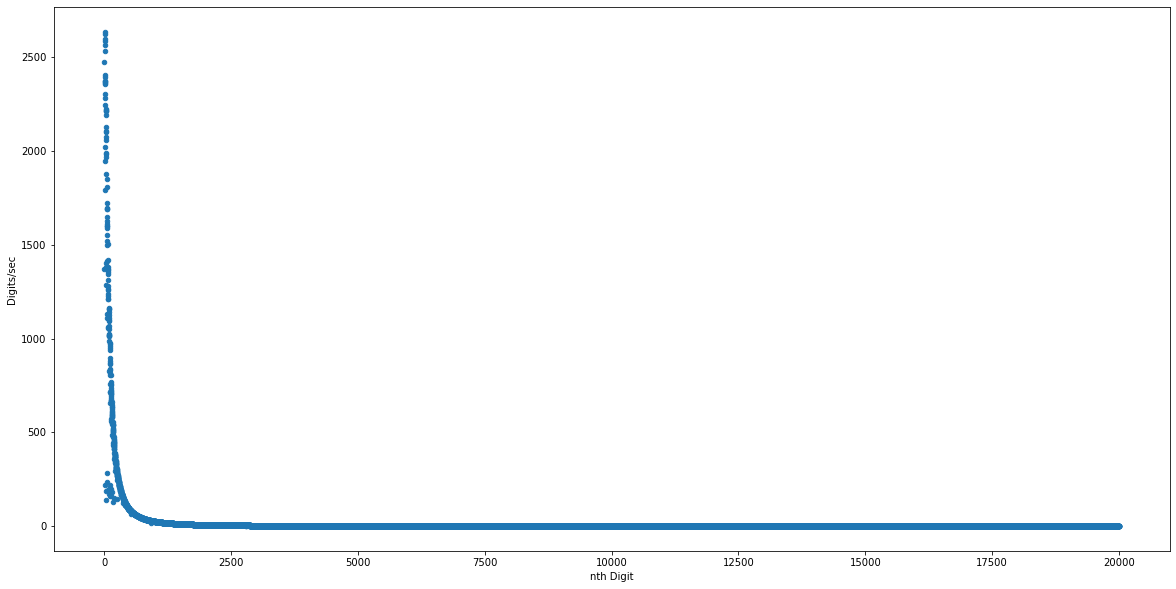

In [1]:
import pandas as pd

bellard_rate_df = pd.read_csv('data/bellard_pi_digitGen_rate.csv')
bellard_rate_df.plot.scatter(x="nth Digit", y="Digits/sec", figsize=(20, 10))

As seen in the plot, the rate at which digits of $\pi$ are being generated decreases drastically on the interval $[1, 1500]$. It appears the rate of change looks like an amplified form of exponential decay. However, this can not be guaranteed without running regression analysis. The cluster of values that seem out of place for $ 1 \leq x \leq 250$ was discussed earlier in the last paragraph of *Precision Timing*. They will be dropped from the dataset as to not introduce ambiguity when running regression analysis.

<AxesSubplot:xlabel='nth Digit', ylabel='Digits/sec'>

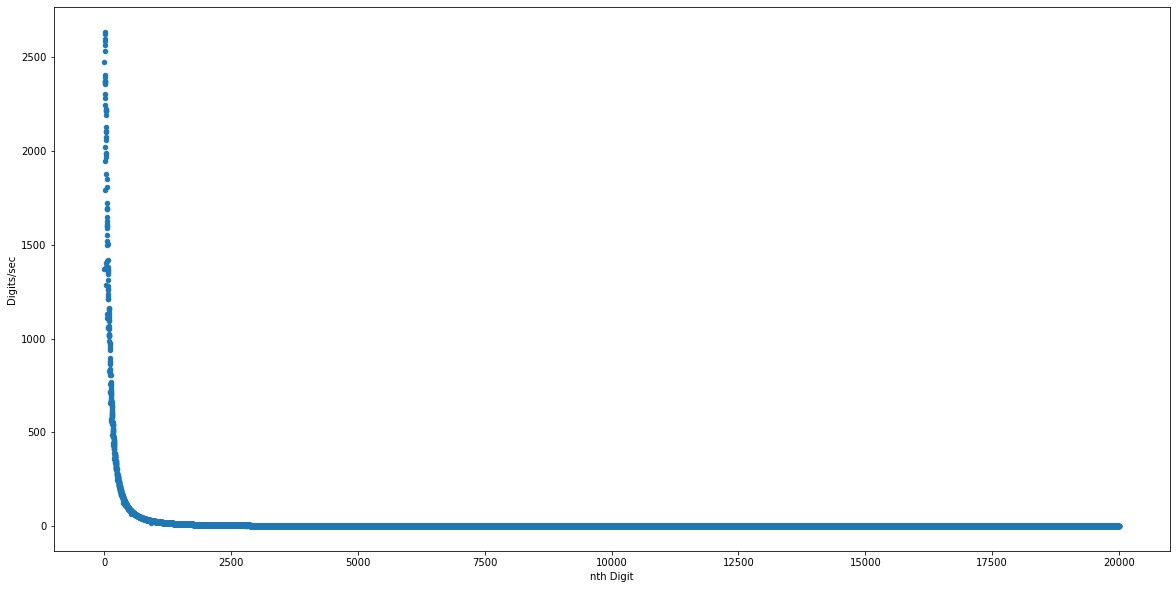

In [2]:
bellard_rate_df.drop(bellard_rate_df[(bellard_rate_df["nth Digit"] < 250) & (bellard_rate_df["Digits/sec"] < 300)].index, inplace=True)
bellard_rate_df.plot.scatter(x="nth Digit", y="Digits/sec", figsize=(20, 10))

Now that the data is cleaned, regression models can be applied in order to better understand the runtime complexity of Bellard's Algorithm. Besides the regular plot, a log-log plot will be displayed to further verify the accuracy of the curve fit. The results will then be plotted using `matplotlib`, another popular Python library for displaying graphs. Attributable to the nature of empirical data, it is nearly impossible to find a single expression that describes the data. Therefore, a piecewise model will be employed in order to solidify the shape of the data.

Function 1 - Exponential Decay
Coefficients: [2.55453190e+03 4.29185330e+00 6.44206642e-03]
Determination Coefficient: 0.9615222477900208


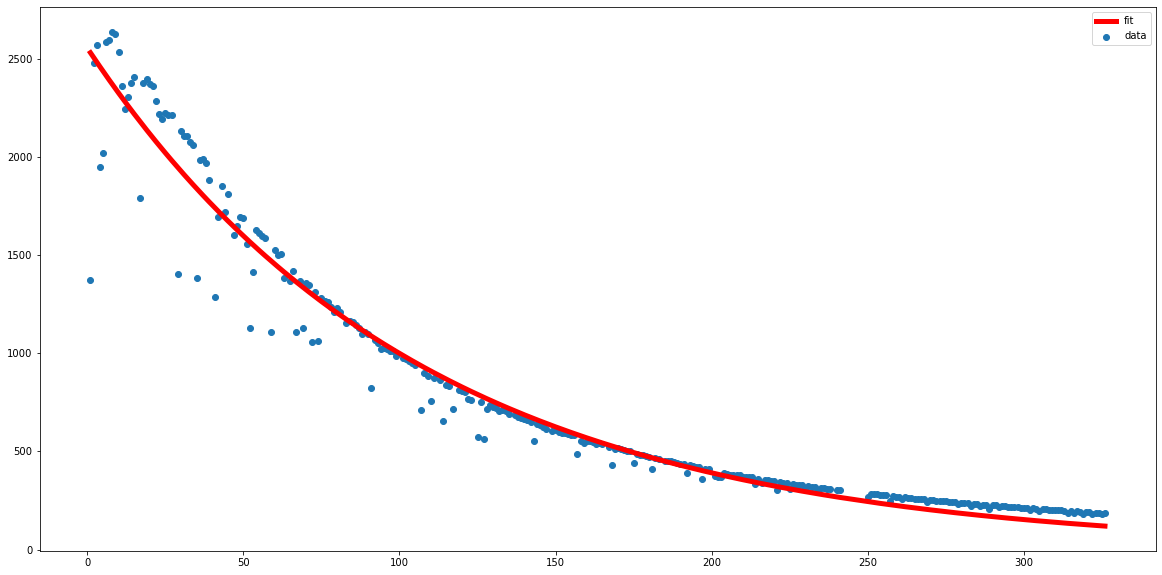

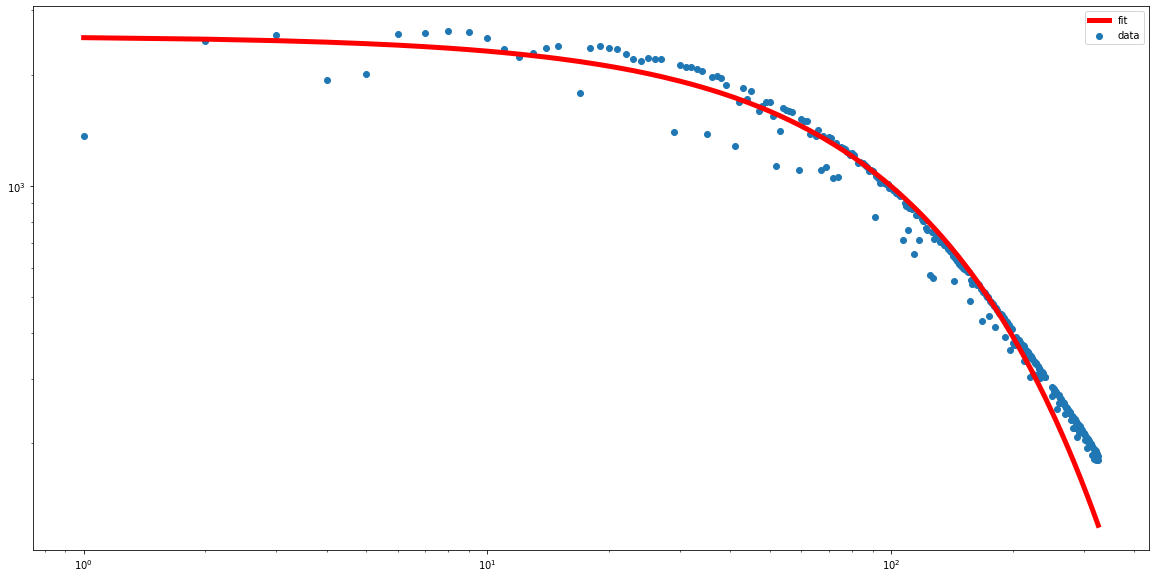

Function 2 - Negative Power Law
Coefficients: [ 6.68087408e+06 -1.81162558e+00]
Determination Coefficient: 0.9991335609609532


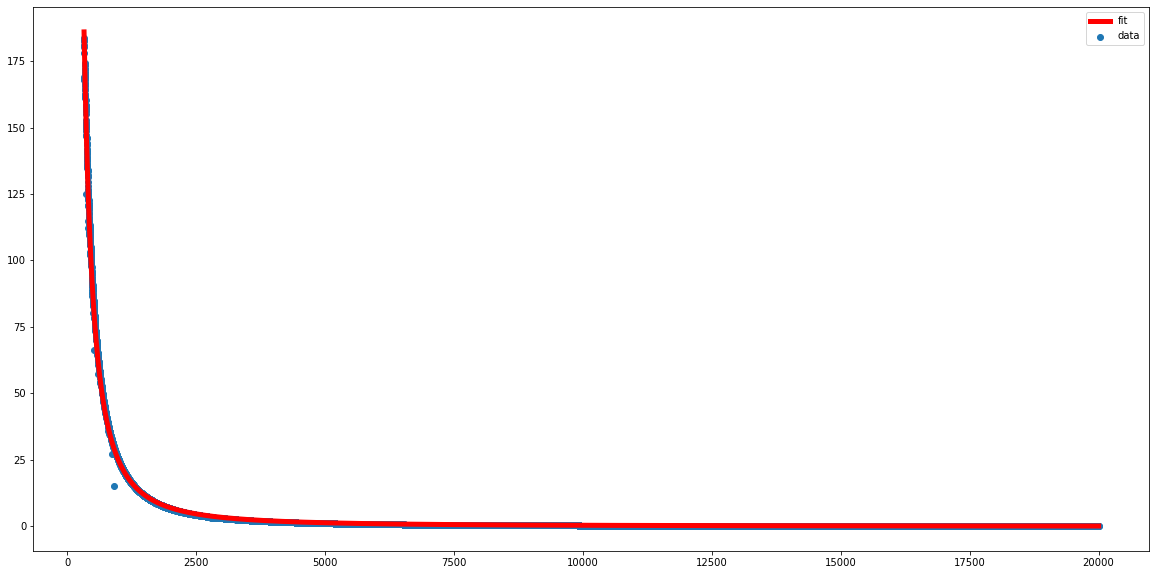

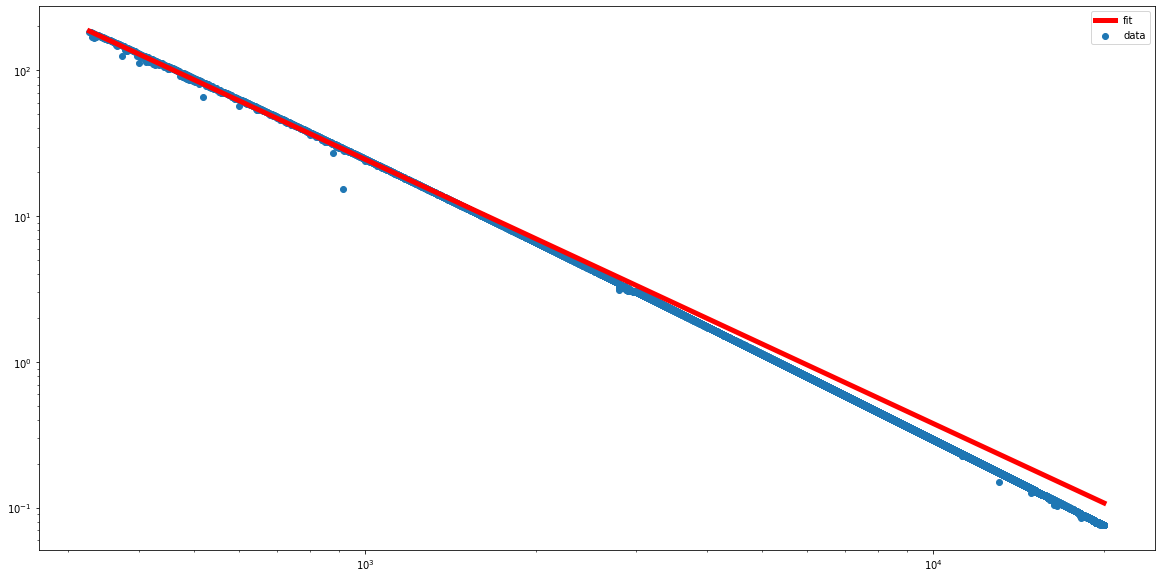

In [3]:
import matplotlib.pyplot as plt
import scipy
import sklearn.metrics

def func(x, a, b, c):
    return a * b ** (-c * x)

def func1(x, a, b):
    return a * x ** b

# chunk dataframe into pieces
bellard_rate_df1 = bellard_rate_df.iloc[:300, :]
bellard_rate_df2 = bellard_rate_df.iloc[300:, :]

popt, pcov = scipy.optimize.curve_fit(func, bellard_rate_df1["nth Digit"], bellard_rate_df1["Digits/sec"])
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
ax.scatter(bellard_rate_df1["nth Digit"], bellard_rate_df1["Digits/sec"], label='data')
ax.plot(bellard_rate_df1["nth Digit"], func(bellard_rate_df1["nth Digit"], *popt), label='fit', color='red', linewidth=5)

fig2 = plt.figure(figsize=(20, 10))
ax2 = fig2.gca()
ax2.scatter(bellard_rate_df1["nth Digit"], bellard_rate_df1["Digits/sec"], label='data')
ax2.loglog(bellard_rate_df1["nth Digit"], func(bellard_rate_df1["nth Digit"], *popt), label='fit', color='red', linewidth=5)

ax.legend()
ax2.legend()
print(f"Function 1 - Exponential Decay\nCoefficients: {popt}")
print(f"Determination Coefficient: {sklearn.metrics.r2_score(bellard_rate_df1['Digits/sec'], func(bellard_rate_df1['nth Digit'], *popt))}")
plt.show()

popt2, pcov2 = scipy.optimize.curve_fit(func1, bellard_rate_df2["nth Digit"], bellard_rate_df2["Digits/sec"])
fig3 = plt.figure(figsize=(20, 10))
ax3 = fig3.gca()
ax3.scatter(bellard_rate_df2["nth Digit"], bellard_rate_df2["Digits/sec"], label='data')
ax3.plot(bellard_rate_df2["nth Digit"], func1(bellard_rate_df2["nth Digit"], *popt2), label='fit', color='red', linewidth=5)

fig4 = plt.figure(figsize=(20, 10))
ax4 = fig4.gca()
ax4.scatter(bellard_rate_df2["nth Digit"], bellard_rate_df2["Digits/sec"], label='data')
ax4.loglog(bellard_rate_df2["nth Digit"], func1(bellard_rate_df2["nth Digit"], *popt2), label='fit', color='red', linewidth=5)

ax3.legend()
ax4.legend()
print(f"Function 2 - Negative Power Law\nCoefficients: {popt2}")
print(f"Determination Coefficient: {sklearn.metrics.r2_score(bellard_rate_df2['Digits/sec'], func1(bellard_rate_df2['nth Digit'], *popt2))}")
plt.show()

From the plot shown above, it is evident that the data is in the form of $ab^{-cx}$ when $x < 300$ and $ax^b$ when $x \geq 300$, where $a, b, c$ are all constants. The regression analysis was very successful, having $R_\text{exp}^2 > 0.96%$ and $R_\text{pow}^2 > 0.999$. As discussed in the beginning of *Methodology*, this model is specific to the hardware that ran Bellard's Algorithm, and although other machines may not have the same coefficients, this general piecewise form should still persist. Plugging in the coefficients into the model yields the differential equation:

\begin{equation}
    B'(x) = \frac{dB}{dx} = 
    \begin{cases}
        2554.5319(4.2918533)^{-0.00644206642x} & 1 \leq x < 300 \\
        6680874.08x^{-1.81162558} &x \geq 300
    \end{cases}
\end{equation}

The equation above models the derivative $B'(x)$, which is the instantaneous rate at which the current digit is being generated. The differential equation will need to be solved in order to find the true runtime complexity $B(x)$, the integral of $B'(x)$. Once solved, $B(x)$ can be reduced to a general form that is synonymous with big-O. Following through with seperation of variables by multiplying $dx$ to both sides:

\begin{equation}
    dB =
    \begin{cases}
        2554.5319(4.2918533)^{-0.00644206642x} dx & 1 \leq x < 300 \\
        6680874.08x^{-1.81162558} dx &x \geq 300
    \end{cases}
\end{equation}

Once the variables have been seperated, to solve for $B(x)$, the integral has to be taken on both sides:

\begin{equation}
\displaystyle
    \int dB =
    \begin{cases}
        \int 2554.5319(4.2918533)^{-0.00644206642x} dx & 1 \leq x < 300 \\
        \int 6680874.08x^{-1.81162558} dx &x \geq 300
    \end{cases}
\end{equation}

Integrating the exponential decay function first, the following steps are taken:

\begin{equation}
\begin{aligned}
\displaystyle
\int dB_\text{exp} &= \int 2554.5319(4.2918533)^{-0.00644206642x} dx \\
& = 2554.5319 \int 4.2918533^{-0.00644206642x} dx \\
& = \frac{2554.5319}{-0.00644206642} \int 4.2918533^{-0.00644206642x} d(-0.00644206642x) \\
& = -396539.2055 \int 4.2918533^{-0.00644206642x} d(-0.00644206642x) \\
B_\text{exp}(x) & = -396539.2055 \frac{4.2918533^{-0.00644206642x}}{\ln(4.2918533)} + C \\
& = C - 272214(4.2918533)^{-0.00644207x}
\end{aligned}
\end{equation}

The indefinite integral has been solved and the general form of $B_\text{exp}(x)$ is presented. However, the equation is incomplete due to the constant of integration. To mitigate this inconsistency, a initial condition will be subsituted into $B_\text{exp}(x)$ to solve for $C$. It is fairly obvious that the time generating zero digits of $\pi$ will be instant. Thus, the initial condition will be $B_\text{exp}(0) = 0$.

$$
B_\text{exp}(0) = 0 = C - 272214(4.2918533)^{-0.00644207(0)} \\
0 = C - 272214(4.2918533)^{0} \\
0 = C - 272214 \\
C = 272214
$$

Now, if $C$ is subsituted back into the general form of $B_\text{exp}(x)$, the runtime model for Bellard's Algorithm is:

\begin{equation}
\begin{aligned}
\displaystyle
B_\text{exp}(x) & = 272214 - 272214(4.2918533)^{-0.00644207x} \\
& = 272214(1 - 4.2918533^{-0.00644207x})
\end{aligned}
\end{equation}

Nonetheless, this only shows the amount of digits Bellard's Algorithm will compute given $x$ seconds to do so. To get the accurate time complexity and the appropriate labels, the inverse $B_\text{exp}^{-1}(x)$ will correct the axes to "Time Spent Computing vs. Amount of Digits Requested."

$$
x = 272214(1 - 4.2918533^{-0.00644207B_\text{exp}^{-1}(x)}) \\
B_\text{exp}^{-1}(x) = -106.561 \ln(0.00000367358(272214 - x))
$$

The same steps applied above to the exponential function will also have to be applied to the power function. First, take the integral of $B_\text{pow}'(x)$:

\begin{equation}
\begin{aligned}
\displaystyle
\int dB_\text{pow} &= \int 6680874.08x^{-1.81162558} dx \\
& = 6680874.08 \int x^{-1.81162558} dx \\
B_\text{pow}(x) & = 6680874.08 \frac{x^{1-1.81162558}}{1-1.81162558} + C \\
& = C - 8231473x^{-0.81162558}
\end{aligned}
\end{equation}

For the constant of integration $C$, a initial condition of $B_\text{pow}(0) = 0$ will result in undefined behavior as $\displaystyle \lim_{x \to 0^+} B_\text{pow}(x) = -\infty$. Since the piecewise function defines $B_\text{pow}(x)$ from $x \geq 300$, the initial condition will be $B_\text{pow}(300) = 0.757054$ as the algorithm ran for 0.757 seconds when generating 300 digits of $\pi$.

$$
B_\text{exp}(300) = 0.757054 = C - 8231473(300)^{-0.81162558} \\
0.757054 = C - 80349.3897947 \\
C = 80350.1468487
$$

Just like the exponential function, the axes for the power function are swapped. Therefore the inverse $B_\text{pow}^{-1}(x)$ will need to be taken:

$$
x = 80350.1468487 - 8231473B_\text{pow}^{-1}(x)^{-0.81162558}\\
B_\text{pow}^{-1}(x) = 331533000(80350.1 - x)^{-1.232}
$$

This inverse function is offseted by about 302 seconds due to rounding errors. To adjust the error and join the two piecewise segments (to a certain extent), the new inverse function will become $B_\text{pow}^{-1}(x) = 331533000(80350.1 - x)^{-1.232} - 301.5892$. Finally, the piecewise function that describes Bellard's Algorithm can finally be joined together to form the final runtime model:

\begin{equation}
    B(x) = 
    \begin{cases}
        -106.561 \ln(0.00000367358(272214 - x)) &1 \leq x < 300 \\
        331533000(80350.1 - x)^{-1.232} - 301.5892 &x \geq 300
    \end{cases}
\end{equation}

Plotting the piecewise function $B(x)$ in `matplotlib`,

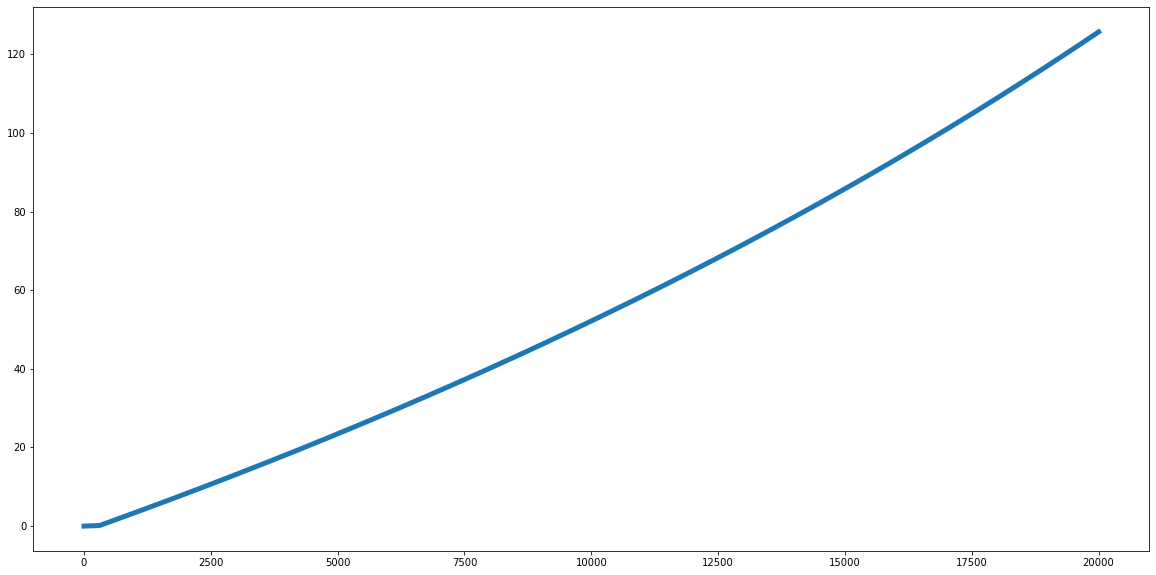

In [4]:
import numpy as np

def piecewiseBellard(x):
    if 1 <= x < 300:
        return -106.561 * np.log(0.00000367358 * (272214 - x))
    elif x >= 300:
        return 331533000 * (80350.1 - x) ** (-1.232) - 301.5892

fig5 = plt.figure(figsize=(20, 10))
ax5 = fig5.gca()
x = np.arange(1., 20000., 1)
ax5.plot(x, list(map(piecewiseBellard, x)),linewidth=5)
plt.show()

it is apparent that, except for $1 \leq x < 300$, the time complexity grows exponentially. The exact numbers do not mean anything, as different machines can replicate different speeds when calculating $\pi$. Even then, it would still be insightful to see how long the on-site hardware would take when calculating $x$ digits of $\pi$.

| Digits of $\pi$ | Time spent | Durations of events comparable to time spent
| --- | --- | ---
| 300 or below | Almost instant | Fast human eye blink.
| 1000 | 3.4 seconds | Average time to wear a shirt.
| 5000 | 23.468 seconds | Recommended hand-washing duration.
| 10000 | 52.13 seconds | Humans will eat 6 million pounds of food.
| 30000 | 3 min 53 sec | An average human heart will have beat 300 times.
| 50000 | 11 min 35 sec | Half the duration of a ice hockey game.
| 80000 | 2 days 19 hours | Twice the lifespan of a mayfly.
| 80300 | 1 month 21 hours | Time it takes to crack a 17-digit numerical pin.

## Conclusion
As Bellard stated, his algorithm can compute any digit of $\pi$ in $O(n^2)$ time [1]. While the empirical data gathered by the on-site hardware does not exactly match $O(n^2)$, the data does show that Bellard's Algorithm stays in polynomial time. This confirms that calculating the digits of $\pi$ is a P-Class problem from an empirical standpoint. The predicted function for Bellard's Algorithm has an asymptote around 80350. This critical error may either be caused by the wrong model being used or insufficient trends causing regression analysis to not converge at a local optima. While this error throws off the accuracy of the function around $x \approx 80350$, the fact that Bellard's Algorithm runs in polynomial time still holds true and is proven by data on the interval $[1, 80300]$. More research will have to be done in order to better calculate digits of $\pi$ and measure the runtime complexity of said algorithms, but this study shows that even with overhead and real-life inconsistencies, the algorithm still holds true to its time complexity.

## References

1. Fabrice Bellard. 2007. *Computation of the n'th digit of pi in any base in O(n^2).* (February 2007). Retrieved April 6, 2022 from https://bellard.org/pi/pi_n2/pi_n2.html 
2. Simon Plouffe. 1996. *On the computation of the n^th decimal digit of various transcendental numbers.* arXiv.org (1996). DOI:http://dx.doi.org/10.48550/arXiv.0912.0303 
3. Michael D. Huberty. 1997. *100,000 Digits of Pi.* (July 1997). Retrieved April 10, 2022 from http://www.geom.uiuc.edu/~huberty/math5337/groupe/digits.html 
4. International Organization for Standardization. *C++ International Standard*. (November 2017). Retrieved April 10, 2022 from http://www.open-std.org/jtc1/sc22/wg21/docs/papers/2017/n4713.pdf 